In [1]:
import math
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import transforms
from torchvision.datasets import FashionMNIST
from sklearn.metrics import confusion_matrix


### Import and Load Dataset

In [ ]:
# Define transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load the full dataset
full_dataset = FashionMNIST(root='./data', train=True, download=True, transform=transform)

# Define split sizes
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size

# Perform the split
train_dataset, test_dataset = random_split(full_dataset, [train_size, val_size])

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

### ViT Definition

In [ ]:
# MLP module for transformer block
class MLP(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.dense_1 = nn.Linear(config["hidden_size"], config["intermediate_size"])
        self.activation = nn.GELU()
        self.dense_2 = nn.Linear(config["intermediate_size"], config["hidden_size"])
        self.dropout = nn.Dropout(config["hidden_dropout_prob"])
    def forward(self, x):
        x = self.dense_1(x)
        x = self.activation(x)
        x = self.dense_2(x)
        x = self.dropout(x)
        return x

# Converts images into patches and projects them into a latent space
class PatchEmbeddings(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.image_size = config["image_size"]
        self.patch_size = config["patch_size"]
        self.num_channels = config["num_channels"]
        self.hidden_size = config["hidden_size"]
        self.num_patches = (self.image_size // self.patch_size) ** 2
        self.projection = nn.Conv2d(self.num_channels, self.hidden_size,
                                    kernel_size=self.patch_size, stride=self.patch_size)
    def forward(self, x):
        # x: (batch, channels, image_size, image_size)
        x = self.projection(x)
        x = x.flatten(2).transpose(1, 2)  # (batch, num_patches, hidden_size)
        return x

# Adds a learnable [CLS] token and positional embeddings
class Embeddings(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.patch_embeddings = PatchEmbeddings(config)
        self.cls_token = nn.Parameter(torch.randn(1, 1, config["hidden_size"]))
        self.position_embeddings = nn.Parameter(
            torch.randn(1, self.patch_embeddings.num_patches + 1, config["hidden_size"]))
        self.dropout = nn.Dropout(config["hidden_dropout_prob"])
    def forward(self, x):
        x = self.patch_embeddings(x)
        batch_size = x.size(0)
        cls_tokens = self.cls_token.expand(batch_size, -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)  # Prepend [CLS] token
        x = x + self.position_embeddings
        return self.dropout(x)

# A single attention head
class AttentionHead(nn.Module):
    def __init__(self, hidden_size, attention_head_size, dropout, bias=True):
        super().__init__()
        self.query = nn.Linear(hidden_size, attention_head_size, bias=bias)
        self.key = nn.Linear(hidden_size, attention_head_size, bias=bias)
        self.value = nn.Linear(hidden_size, attention_head_size, bias=bias)
        self.dropout = nn.Dropout(dropout)
    def forward(self, x):
        query = self.query(x)
        key = self.key(x)
        value = self.value(x)
        scores = torch.matmul(query, key.transpose(-1, -2)) / math.sqrt(query.size(-1))
        attn = nn.functional.softmax(scores, dim=-1)
        attn = self.dropout(attn)
        output = torch.matmul(attn, value)
        return output, attn

# Multi-head attention using multiple attention heads
class MultiHeadAttention(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.hidden_size = config["hidden_size"]
        self.num_heads = config["num_attention_heads"]
        self.head_dim = self.hidden_size // self.num_heads
        self.heads = nn.ModuleList([
            AttentionHead(self.hidden_size, self.head_dim,
                          config["attention_probs_dropout_prob"], config["qkv_bias"])
            for _ in range(self.num_heads)
        ])
        self.output_projection = nn.Linear(self.num_heads * self.head_dim, self.hidden_size)
        self.output_dropout = nn.Dropout(config["hidden_dropout_prob"])
    def forward(self, x, output_attentions=False):
        head_outputs = [head(x)[0] for head in self.heads]
        concat = torch.cat(head_outputs, dim=-1)
        output = self.output_projection(concat)
        return self.output_dropout(output)

# Transformer block with multi-head attention, MLP, layer normalization and skip connections
class Block(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.attention = MultiHeadAttention(config)
        self.norm1 = nn.LayerNorm(config["hidden_size"])
        self.mlp = MLP(config)
        self.norm2 = nn.LayerNorm(config["hidden_size"])
    def forward(self, x):
        attn_out = self.attention(self.norm1(x))
        x = x + attn_out  # Skip connection
        mlp_out = self.mlp(self.norm2(x))
        return x + mlp_out  # Skip connection

# Encoder: Stack of transformer blocks
class Encoder(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.blocks = nn.ModuleList([Block(config) for _ in range(config["num_hidden_layers"])])
    def forward(self, x):
        for block in self.blocks:
            x = block(x)
        return x

# ViT model that assembles all components for classification
class ViT(nn.Module):
    def __init__(self, image_size, patch_size, emb_size, num_layers, num_heads, num_classes, 
                 num_channels=1, hidden_dropout_prob=0.0, attention_probs_dropout_prob=0.0, qkv_bias=True):
        super().__init__()
        # Build a configuration dictionary
        config = {
            "image_size": image_size,
            "patch_size": patch_size,
            "num_channels": num_channels,
            "hidden_size": emb_size,
            "num_hidden_layers": num_layers,
            "num_attention_heads": num_heads,
            "hidden_dropout_prob": hidden_dropout_prob,
            "attention_probs_dropout_prob": attention_probs_dropout_prob,
            "qkv_bias": qkv_bias,
            "num_classes": num_classes,
            "intermediate_size": 4 * emb_size,
        }
        self.embedding = Embeddings(config)
        self.encoder = Encoder(config)
        self.classifier = nn.Linear(emb_size, num_classes)
    
    def forward(self, x):
        x = self.embedding(x)
        x = self.encoder(x)
        logits = self.classifier(x[:, 0])  # Use [CLS] token's output for classification
        return logits


### Training and evaluation functions

In [4]:
# Setup training components
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# Training and evaluation routines
def train_epoch(model, loader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * images.size(0)
    return total_loss / len(loader.dataset)

def evaluate(model, loader, device):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    return correct / total



### Experiment Function
- Sets up the model with the specified parameters.
- Uses the same optimizer and scheduler for all experiments.
- Trains the model for a specified number of epochs.
- Evaluates the model on the test set.
- Saves the resulting model
- Returns the test accuracy, loss, and confusion matrix.



In [5]:
# Training loop
def expirement(num_layers, num_heads, epochs=20):
    model = ViT(image_size=28, patch_size=4, emb_size=64, num_layers=num_layers, num_heads=num_heads, num_classes=10).to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-2)
    criterion = nn.CrossEntropyLoss()
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)
    
    num_epochs = epochs
    train_losses = []
    test_accuracies = []
    print(f"Layers: {num_layers}, Heads: {num_heads}")
    for epoch in range(num_epochs):
        loss = train_epoch(model, train_loader, optimizer, criterion, device)
        train_losses.append(loss)
        test_acc = evaluate(model, test_loader, device)
        test_accuracies.append(test_acc)
        scheduler.step()  # Update learning rate
        print(f"Epoch {epoch+1}/{num_epochs} - Loss: {loss:.4f} - Test Accuracy: {test_acc:.4f}")

    model_save_path = f"ViT_layers{num_layers}_heads{num_heads}.pth"
    torch.save(model.state_dict(), model_save_path)
    print(f"Model saved to '{model_save_path}'")

    all_preds = []
    all_labels = []
    model.eval()
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            
    cm = confusion_matrix(all_labels, all_preds)
    
    return train_losses, test_accuracies, cm

### Experiment Loop
- Iterates through the specified number of experiments.
- Saves the results of each experiment in a dictionary.

In [6]:
def experiment_range(min_layer, max_layer, min_head, max_head, epochs):
    experiment_dict = {}
    for layer in range(min_layer, max_layer+1):
        for head in range(min_head, max_head+1):
            key = f"layer-{layer} head-{head}"
            experiment_dict[key] = expirement(num_layers=layer, num_heads=head, epochs=epochs)
    return experiment_dict

### Experiment Loop Called
- The experiment loop is called with the specified parameters: 
    - Min Layer Size, Max Layer Size, Min Head Number, Max Head Number

In [7]:
min_layer=4
max_layer=8
min_head=2
max_head=4
epochs=25

experiment_dict = experiment_range(min_layer=min_layer, max_layer=max_layer, min_head=min_head, max_head=max_head, epochs=epochs)

Layers: 4, Heads: 2
Epoch 1/25 - Loss: 0.8210 - Test Accuracy: 0.7678
Epoch 2/25 - Loss: 0.5701 - Test Accuracy: 0.7803
Epoch 3/25 - Loss: 0.5261 - Test Accuracy: 0.8093
Epoch 4/25 - Loss: 0.4896 - Test Accuracy: 0.8220
Epoch 5/25 - Loss: 0.4833 - Test Accuracy: 0.8339
Epoch 6/25 - Loss: 0.3849 - Test Accuracy: 0.8500
Epoch 7/25 - Loss: 0.3742 - Test Accuracy: 0.8605
Epoch 8/25 - Loss: 0.3632 - Test Accuracy: 0.8462
Epoch 9/25 - Loss: 0.3616 - Test Accuracy: 0.8456
Epoch 10/25 - Loss: 0.3535 - Test Accuracy: 0.8600
Epoch 11/25 - Loss: 0.2908 - Test Accuracy: 0.8709
Epoch 12/25 - Loss: 0.2752 - Test Accuracy: 0.8773
Epoch 13/25 - Loss: 0.2683 - Test Accuracy: 0.8766
Epoch 14/25 - Loss: 0.2567 - Test Accuracy: 0.8748
Epoch 15/25 - Loss: 0.2462 - Test Accuracy: 0.8819
Epoch 16/25 - Loss: 0.1987 - Test Accuracy: 0.8858
Epoch 17/25 - Loss: 0.1826 - Test Accuracy: 0.8849
Epoch 18/25 - Loss: 0.1689 - Test Accuracy: 0.8858
Epoch 19/25 - Loss: 0.1589 - Test Accuracy: 0.8838
Epoch 20/25 - Loss: 

### Results
- The training losses for each experiment are plotted on the same graph.
- The test accuracies for each experiment are plotted on the same graph.
- The confusion matrices for each experiment are plotted in a grid.

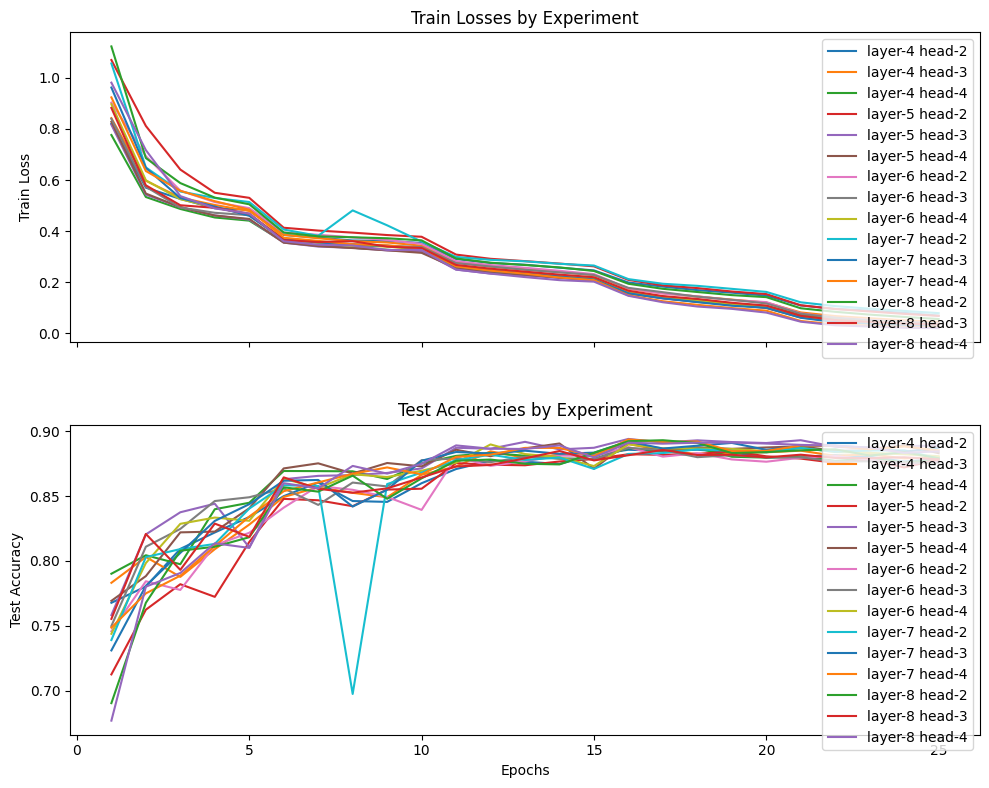

In [ ]:
import matplotlib.pyplot as plt

keys_to_plot = list(experiment_dict.keys())

fig, (ax_loss, ax_acc) = plt.subplots(2, 1, sharex=True, figsize=(10, 8))

for key in keys_to_plot:
    train_losses, test_accuracies, _ = experiment_dict[key]
    epochs = range(1, len(train_losses) + 1)
    ax_loss.plot(epochs, train_losses, label=f"{key}")
    ax_acc.plot(epochs, test_accuracies, label=f"{key}")

ax_loss.set_ylabel("Train Loss")
ax_loss.set_title("Train Losses by Experiment")
ax_loss.legend()

ax_acc.set_xlabel("Epochs")
ax_acc.set_ylabel("Test Accuracy")
ax_acc.set_title("Test Accuracies by Experiment")
ax_acc.legend()

plt.tight_layout()
plt.show()

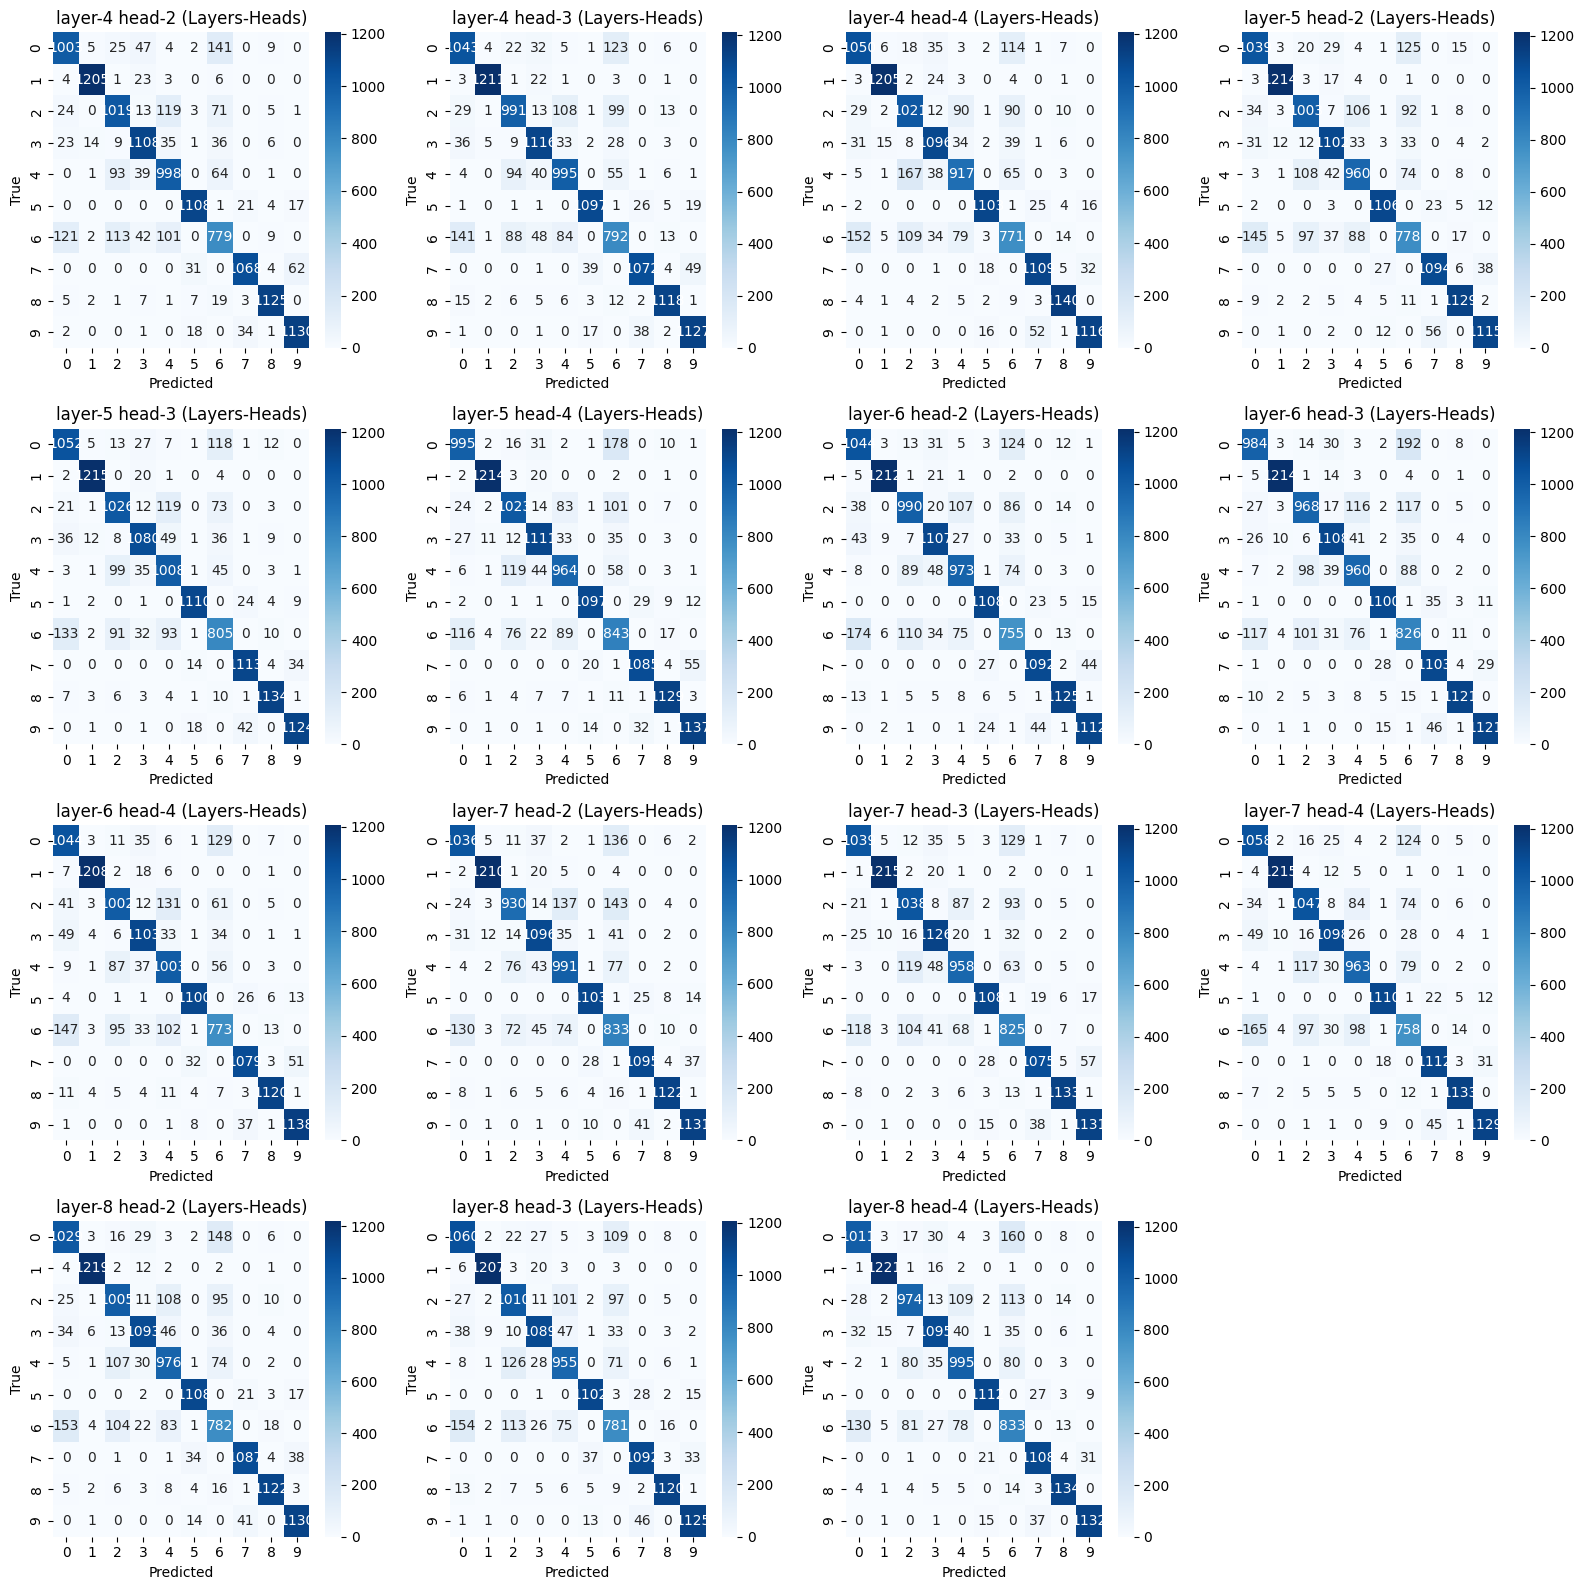

In [9]:
import math
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Get experiment keys and count total experiments
keys_to_plot = list(experiment_dict.keys())
n_experiments = len(keys_to_plot)

# Dynamically determine grid dimensions based on total experiments
cols = math.ceil(math.sqrt(n_experiments))
rows = math.ceil(n_experiments / cols)

# Create subplots with dynamic grid size
fig, axes = plt.subplots(rows, cols, figsize=(cols * 4, rows * 4))
# Ensure axes is a flat list even if there's only one subplot
if isinstance(axes, np.ndarray):
    axes = axes.flatten()
else:
    axes = [axes]

# Plot each confusion matrix in a subplot
for ax, key in zip(axes, keys_to_plot):
    _, _, cm = experiment_dict[key]
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=ax)
    ax.set_title(f"{key} (Layers-Heads)")
    ax.set_xlabel("Predicted")
    ax.set_ylabel("True")

# Turn off any unused subplots
for ax in axes[n_experiments:]:
    ax.axis("off")

plt.tight_layout()
plt.show()